### Versión funcional del [`algoritmo de shor`](https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/shor.ipynb) en la versión actual
Se hicieron cambios principalmente en el acceso a diferentes funcionalidades de la librería de qiskit, por ejemplo para hacer uso del simulador Aer, el cual cambió con respecto al usado originalmente en el código.

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Operator

from math import gcd
from fractions import Fraction

In [6]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U

In [7]:
N_COUNT = 8
a = 7

In [8]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

In [9]:
qc = QuantumCircuit(N_COUNT + 4, N_COUNT)

# in state |+>
for q in range(N_COUNT):
    qc.h(q)

# And auxiliary register in state |1>
qc.x(N_COUNT)

# Do controlled-U operations
for q in range(N_COUNT):
    qc.append(c_amod15(a, 2**q),
             [q] + [i+N_COUNT for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(N_COUNT), range(N_COUNT))

# Measure circuit
qc.measure(range(N_COUNT), range(N_COUNT))
qc.draw(fold=-1)  # -1 means 'do not fold'

┌───┐                                                                                                                             ┌───────┐┌─┐                     
 q_0: ┤ H ├───────■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0      ├┤M├─────────────────────
      ├───┤       │                                                                                                                     │       │└╥┘┌─┐                  
 q_1: ┤ H ├───────┼──────────────■──────────────────────────────────────────────────────────────────────────────────────────────────────┤1      ├─╫─┤M├──────────────────
      ├───┤       │              │                                                                                                      │       │ ║ └╥┘┌─┐               
 q_2: ┤ H ├───────┼──────────────┼──────────────■───────────────────────────────────────────────────────────────────────────────────────┤2      ├─╫──╫─┤M├───────────────
      ├───┤       │              │              │                                                                                       │       │ ║  ║ └╥┘┌─┐            
 q_3: ┤ H ├───────┼──────────────┼──────────────┼──────────────■────────────────────────────────────────────────────────────────────────┤3      ├─╫──╫──╫─┤M├────────────
      ├───┤       │              │              │              │                                                                        │  QFT† │ ║  ║  ║ └╥┘┌─┐         
 q_4: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────■─────────────────────────────────────────────────────────┤4      ├─╫──╫──╫──╫─┤M├─────────
      ├───┤       │              │              │              │              │                                                         │       │ ║  ║  ║  ║ └╥┘┌─┐      
 q_5: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────■─────────────────────────────────────────┤5      ├─╫──╫──╫──╫──╫─┤M├──────
      ├───┤       │              │              │              │              │               │                                         │       │ ║  ║  ║  ║  ║ └╥┘┌─┐   
 q_6: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────■─────────────────────────┤6      ├─╫──╫──╫──╫──╫──╫─┤M├───
      ├───┤       │              │              │              │              │               │               │                         │       │ ║  ║  ║  ║  ║  ║ └╥┘┌─┐
 q_7: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────┼────────────────■────────┤7      ├─╫──╫──╫──╫──╫──╫──╫─┤M├
      ├───┤┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴───────┐┌──────┴───────┐┌──────┴───────┐┌───────┴───────┐└───────┘ ║  ║  ║  ║  ║  ║  ║ └╥┘
 q_8: ┤ X ├┤0            ├┤0            ├┤0            ├┤0            ├┤0             ├┤0             ├┤0             ├┤0              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
      └───┘│             ││             ││             ││             ││              ││              ││              ││               │          ║  ║  ║  ║  ║  ║  ║  ║ 
 q_9: ─────┤1            ├┤1            ├┤1            ├┤1            ├┤1             ├┤1             ├┤1             ├┤1              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
           │  7^1 mod 15 ││  7^2 mod 15 ││  7^4 mod 15 ││  7^8 mod 15 ││  7^16 mod 15 ││  7^32 mod 15 ││  7^64 mod 15 ││  7^128 mod 15 │          ║  ║  ║  ║  ║  ║  ║  ║ 
q_10: ─────┤2            ├┤2            ├┤2            ├┤2            ├┤2             ├┤2             ├┤2             ├┤2              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
           │             ││             ││             ││             ││              ││              ││              ││               │          ║  ║  ║  ║  ║  ║  ║  ║ 
q_11: ─────┤3            ├┤3            ├┤3            ├┤3            ├┤3             ├┤3       

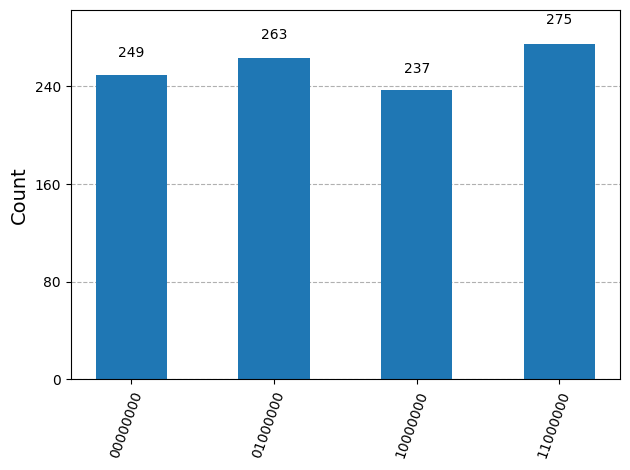

In [ ]:
counts = AerSimulator().run(qc.decompose()).result().get_counts()
plot_histogram(counts)

# aer_sim = Aer.get_backend('aer_simulator')
# t_qc = transpile(qc, aer_sim)
# counts = aer_sim.run(t_qc).result().get_counts()


In [15]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)
    phase = decimal/(2**N_COUNT)
    measured_phases.append(phase)
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**N_COUNT} = {phase:.2f}"])
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0  10000000(bin) = 128(dec)  128/256 = 0.50
1  11000000(bin) = 192(dec)  192/256 = 0.75
2  01000000(bin) =  64(dec)   64/256 = 0.25
3  00000000(bin) =   0(dec)    0/256 = 0.00


In [19]:
def get_factors(measured_phases, a, N=15):
    factors_found = []
    
    for phase in measured_phases:
        frac = Fraction(phase).limit_denominator(N)
        r = frac.denominator
        
        if r % 2 == 0:
            guesses = [gcd(a**(r//2) - 1, N), gcd(a**(r//2) + 1, N)]
            
            for guess in guesses:
                if guess not in [1, N] and guess not in factors_found:
                    if N % guess == 0:
                        factors_found.append(guess)
                        factors_found.append(N // guess)
    
    factors_found = sorted(list(set(factors_found)))
    
    if not factors_found:
        print("No se encontraron factores.")
    
    return factors_found

factors = get_factors(measured_phases, a)

if factors:
    product = 1
    for factor in factors:
        print(f"Factor: {factor}")

Factor: 3
Factor: 5


### Versión general
Crear una versión general del algoritmo de shor es algo con lo que he encontrado muchos problemas incluso en libros, también hay recursos que hablan sobre como craer el circuito que represente dicho Uf, finalmente para probar una versión más general del algoritmo, lo que decidi, en vista de la complejidad de la creación de una forma cuantica general, es calcular dicha compuerta de forma clasica, esto claramente limita el número del número que podemos ingresar puesto que la principal ventaja de la versión cuantica es la reducción en la complejidad computacional.

<table>
  <tr>
    <td><img src="images/AlgoritmosCuanticos.jpg" alt="Descripción imagen 1"></td>
    <td><img src="images/Libro1.jpg" alt="Descripción imagen 2"></td>
  </tr>
</table>

In [ ]:
def c_amodN(a, power, N):
    if gcd(a, N) != 1:
        raise ValueError(f"a={a} y N={N} no son coprimos")
    
    n_count = max(3, N.bit_length())
    
    qc = QuantumCircuit(n_count, name=f"{a}^{power} mod {N}")
    
    permutation = {}
    for x in range(N):
        result = (pow(a, power, N) * x) % N
        permutation[x] = result
    
    dim = 2**n_count
    matrix = np.zeros((dim, dim), dtype=complex)
    
    for i in range(N):
        matrix[permutation[i], i] = 1.0
    
    for i in range(N, dim):
        matrix[i, i] = 1.0
    
    op = Operator(matrix)
    gate = op.to_instruction()
    gate.name = f"{a}^{power} mod {N}"
    
    c_U = gate.control(1)
    
    return c_U

In [ ]:
def shor_factorize_general(N, a=None, max_attempts=3):
    
    if N <= 1:
        return [N]
    
    if N % 2 == 0:
        return [2, N//2]
    
    from sympy import isprime
    if isprime(N):
        print(f"{N} es un número primo.")
        return [N]
    
    n_size = N.bit_length()
    
    N_COUNT = 2 * n_size
    
    attempts = 0
    all_factors = []
    
    coprimos = [num for num in range(2, N) if gcd(num, N) == 1]
    if not coprimos:
        print(f"Error: No se encontraron valores coprimos con {N}")
        return [N]
    
    print(f"Valores coprimos con {N}: {coprimos if len(coprimos) < 20 else len(coprimos)}")
    
    while attempts < max_attempts and not all_factors:
        if a is None:
            a = random.choice(coprimos)
            if gcd(a, N) != 1:
                print(f"Error: a={a} no es coprimo con N={N}. MCD({a},{N})={gcd(a,N)}")
                continue
        else:
            if gcd(a, N) != 1:
                print(f"Error: El valor proporcionado a={a} no es coprimo con N={N}.")
                print("Seleccionando un valor aleatorio coprimo...")
                a = random.choice(coprimos)
        
        print(f"\nIntento {attempts+1}: Usando a = {a} (verificado coprimo con {N})")
        
        qc = QuantumCircuit(N_COUNT + n_size, N_COUNT)
        
        for q in range(N_COUNT):
            qc.h(q)
        
        qc.x(N_COUNT)
        
        for q in range(N_COUNT):
            try:
                if gcd(a, N) != 1:
                    raise ValueError(f"a={a} y N={N} no son coprimos")
                qc.append(c_amodN(a, 2**q, N),
                         [q] + [i+N_COUNT for i in range(n_size)])
            except Exception as e:
                print(f"Error al crear el circuito: {e}")
                a = None
                break
        
        if a is None:
            continue
        
        qc.append(qft_dagger(N_COUNT), range(N_COUNT))
        
        qc.measure(range(N_COUNT), range(N_COUNT))
        
        print("Ejecutando circuito cuántico...")
        
        simulator = AerSimulator()
        t_qc = transpile(qc, simulator)
        result = simulator.run(t_qc).result()
        counts = result.get_counts()
        
        print("Procesando resultados de medición...")
        
        measured_phases = []
        for output in counts:
            decimal = int(output, 2)
            phase = decimal/(2**N_COUNT)
            measured_phases.append(phase)
        
        print(f"Fases medidas: {[(f'{phase:.4f}') for phase in measured_phases[:10]]}" + 
              ("..." if len(measured_phases) > 10 else ""))
        
        factors = get_factors(measured_phases, a, N)
        if factors:
            all_factors = factors
            print(f"¡Factores encontrados!: {all_factors}")
        else:
            print("No se encontraron factores en este intento.")
            if a in coprimos:
                coprimos.remove(a)
            a = None
            if not coprimos:
                print("¡Se han agotado todos los valores coprimos disponibles!")
                break
        
        attempts += 1
    
    if all_factors:
        print(f"\n¡Éxito! Factorización de {N}: {all_factors}")
        product = 1
        for factor in all_factors:
            product *= factor
        print(f"Verificación: {' × '.join(map(str, all_factors))} = {product} {'✓' if product == N else '✗'}")
    else:
        print(f"\nNo se pudo factorizar {N} después de {max_attempts} intentos.")
    
    return all_factors

In [39]:
shor_factorize_general(39, max_attempts=10)

Valores coprimos con 39: 23

Intento 1: Usando a = 2 (verificado coprimo con 39)
Ejecutando circuito cuántico...
Procesando resultados de medición...
Fases medidas: ['0.0815', '0.1660', '0.6653', '0.4170', '0.5840', '0.0713', '0.0852', '0.0825', '0.5833', '0.5837']...
¡Factores encontrados!: [3, 13]

¡Éxito! Factorización de 39: [3, 13]
Verificación: 3 × 13 = 39 ✓


[3, 13]